<a href="https://colab.research.google.com/github/lygitdata/STATS-415-Project/blob/main/code/STATS_415_Kaggle_Li_Yuan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Data Cleaning

In [2]:
# Import training set
X_train = pd.read_csv('https://stats415.ly.gd.edu.kg/kaggleData/X_train.csv')
y_train = pd.read_csv('https://stats415.ly.gd.edu.kg/kaggleData/y_train.csv')
# Import testing set
X_test = pd.read_csv('https://stats415.ly.gd.edu.kg/kaggleData/X_test.csv')
y_sample = pd.read_csv('https://stats415.ly.gd.edu.kg/kaggleData/y_sample.csv')

# Dummy variable transform
categorical_cols = ['self_eval', 'teacher_eval', 'district']
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
print(X_train.shape)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
print(X_test.shape)

# Drop and save SEQN
SEQN_X_train = X_train['SEQN']
X_train = X_train.drop(columns=['SEQN'])
SEQN_y_train = y_train['SEQN']
y_train = y_train.drop(columns=['SEQN'])
SEQN_X_test = X_test['SEQN']
X_test = X_test.drop(columns=['SEQN'])

(8000, 65)
(4000, 65)


In [3]:
# Scale data
scaler = preprocessing.StandardScaler()
minmax = preprocessing.MinMaxScaler()
X_train[['self_eval_2', 'self_eval_3', 'self_eval_4', 'self_eval_5',
       'district_2', 'district_3', 'district_4', 'district_5', 'district_6',
       'district_7']] = scaler.fit_transform(X_train[[
       'self_eval_2', 'self_eval_3', 'self_eval_4', 'self_eval_5',
       'district_2', 'district_3', 'district_4', 'district_5', 'district_6',
       'district_7']])
X_test[['self_eval_2', 'self_eval_3', 'self_eval_4', 'self_eval_5',
       'district_2', 'district_3', 'district_4', 'district_5', 'district_6',
       'district_7']] = scaler.fit_transform(X_test[[
       'self_eval_2', 'self_eval_3', 'self_eval_4', 'self_eval_5',
       'district_2', 'district_3', 'district_4', 'district_5', 'district_6',
       'district_7']])
X_train[['teacher_eval_2', 'teacher_eval_3',
         'teacher_eval_4', 'teacher_eval_5']] = minmax.fit_transform(X_train[['teacher_eval_2', 'teacher_eval_3',
                                                                              'teacher_eval_4', 'teacher_eval_5']])
X_test[['teacher_eval_2', 'teacher_eval_3',
        'teacher_eval_4', 'teacher_eval_5']] = minmax.fit_transform(X_test[['teacher_eval_2', 'teacher_eval_3',
                                                                            'teacher_eval_4', 'teacher_eval_5']])
# Convert data to numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()

# Model Training

In [4]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.15,
    decay_steps=2000,
    decay_rate=0.9
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_r2_score',
        patience=20,
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        save_best_only=True,
        monitor='val_r2_score',
        mode='max'
    )
]

def build_model():
    model = Sequential([
        layers.Dense(units=4096, activation='elu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(units=2048, activation='elu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(units=512, activation='elu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(units=1, activation='linear')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.R2Score(name='r2_score')]
    )

    return model

kf = KFold(n_splits=15, shuffle=True, random_state=88)

mse_scores = []
r2_scores = []
i = 0
for train_index, val_index in kf.split(X_train):
    i = i + 1
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = build_model()
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=200,
        batch_size=512,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        verbose=0
    )

    y_val_pred = model.predict(X_val_fold, verbose=False)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    mse_scores.append(mse)
    r2 = r2_score(y_val_fold, y_val_pred)
    r2_scores.append(r2)
    print(i, "Fold | Validation MSE =", round(mse, 5), " | Validation Adjusted R^2 =", round(r2, 5))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1 Fold | Validation MSE = 0.29687  | Validation Adjusted R^2 = 0.88043
2 Fold | Validation MSE = 0.27182  | Validation Adjusted R^2 = 0.87969


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3 Fold | Validation MSE = 0.27368  | Validation Adjusted R^2 = 0.88798
4 Fold | Validation MSE = 0.26463  | Validation Adjusted R^2 = 0.86667
5 Fold | Validation MSE = 0.28053  | Validation Adjusted R^2 = 0.88584
6 Fold | Validation MSE = 0.27229  | Validation Adjusted R^2 = 0.88636
7 Fold | Validation MSE = 0.28666  | Validation Adjusted R^2 = 0.8737


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8 Fold | Validation MSE = 0.24894  | Validation Adjusted R^2 = 0.89379
9 Fold | Validation MSE = 0.2684  | Validation Adjusted R^2 = 0.88953
10 Fold | Validation MSE = 0.28011  | Validation Adjusted R^2 = 0.87022
11 Fold | Validation MSE = 0.26554  | Validation Adjusted R^2 = 0.87826
12 Fold | Validation MSE = 0.28587  | Validation Adjusted R^2 = 0.87834
13 Fold | Validation MSE = 0.28906  | Validation Adjusted R^2 = 0.8762
14 Fold | Validation MSE = 0.26907  | Validation Adjusted R^2 = 0.88294
15 Fold | Validation MSE = 0.2664  | Validation Adjusted R^2 = 0.87979


Mean MSE = 0.2746587387828237
Std Dev MSE = 0.01164276110211462
Mean Adj. R^2 = 0.8806490990410294
Std Dev Adj. R^2 =  0.007095798166417374


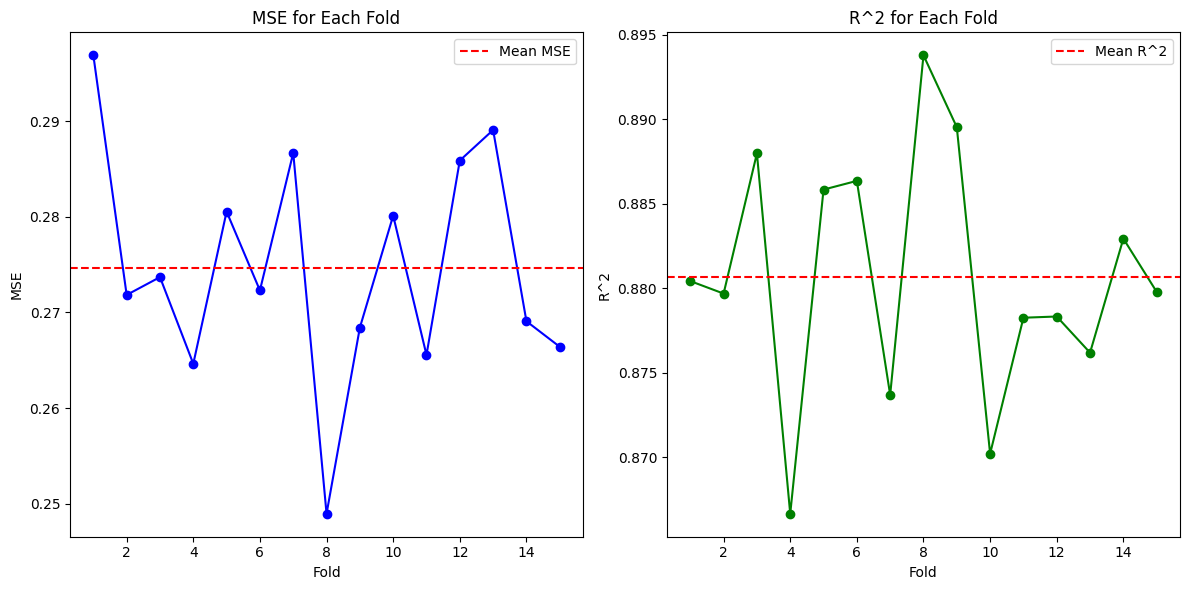

In [5]:
print("Mean MSE =", np.mean(mse_scores))
print("Std Dev MSE =", np.std(mse_scores))
print("Mean Adj. R^2 =", np.mean(r2_scores))
print("Std Dev Adj. R^2 = ", np.std(r2_scores))

# Plot MSEs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(mse_scores) + 1), mse_scores, marker='o', linestyle='-', color='b')
plt.axhline(y=np.mean(mse_scores), color='r', linestyle='--', label='Mean MSE')
plt.title('MSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()

# Plot R^2s
plt.subplot(1, 2, 2)
plt.plot(range(1, len(r2_scores) + 1), r2_scores, marker='o', linestyle='-', color='g')
plt.axhline(y=np.mean(r2_scores), color='r', linestyle='--', label='Mean R^2')
plt.title('R^2 for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R^2')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
y_temp = model.predict(X_train)
mean_squared_error(y_temp, y_train)

250/250 [==============================] - 1s 2ms/step


0.20460156723788464

In [7]:
r2_score(y_temp, y_train)

0.9035581604559466

In [8]:
y_test = model.predict(X_test)
output = pd.DataFrame({'SEQN': SEQN_X_test.values.flatten(), 'y': y_test.flatten()})
out = y_sample.merge(output, on=['SEQN'], how="left")
out = out.drop(columns=['y_x'])
out = out.rename(columns={'y_y': 'y'})
out

125/125 [==============================] - 0s 2ms/step


,SEQN,y
0,492834,1.506949
1,309349,-1.006770
2,468308,-1.279477
3,838812,-2.603849
4,947936,1.214518
...,...,...
3995,971604,0.573724
3996,2790,-0.789801
3997,159210,-0.728733
3998,366040,0.399216


In [9]:
out.to_csv('result.csv', index=False)